<a href="https://colab.research.google.com/github/anujapatil31/Anuja_coursera/blob/master/symbol_classification_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's begin by installing and importing the required libraries.

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Preparing the Dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_path = "/content/drive/MyDrive/P&ID DATA/cropped_img"
classes = os.listdir(train_path)
print(classes)
len(os.listdir(train_path))

['flow_direction', 'separator', 'valve', 'Inside text', 'line_break', 'plug', 'Unidentified', 'Instrument', 'tank_vessel', 'flange_blind', 'Actuator', 'connector', 'Concentric', 'engine', 'flange']


15

In [4]:
# Label Overview
classes_labels = { 0:'Actuator',
            1:'Concentric', 
            2:'Inside text', 
            3: 'Instrument',
            4: 'Unidentified',
            5: 'connector',
            6: 'engine',
            7: 'flange',
            8: 'flange_blind',
            9: 'flow_direction',
            10: 'line_break',
            11: 'plug',
            12: 'separator',
            13: 'tank_vessel',
            14: 'valve'                    
            
             }

In [5]:
# Data transforms (normalization & data augmentation)
#stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform = tt.Compose(
    [
        tt.Compose([tt.Scale((64,64))]),
        tt.ToTensor(),
        #tt.Normalize(*stats,inplace=True)
    ]   
    
)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [6]:
# PyTorch datasets
dataset = ImageFolder(train_path, transform)
len(dataset)
 

3724

In [7]:
dataset[0]

(tensor([[[0.9843, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9725, 0.9961, 1.0000,  ..., 0.7529, 0.7765, 0.8471],
          [0.9255, 0.9882, 1.0000,  ..., 0.8392, 0.9020, 0.8431],
          ...,
          [0.8863, 0.9843, 1.0000,  ..., 1.0000, 0.9843, 0.8745],
          [0.9216, 0.9922, 1.0000,  ..., 0.9882, 0.9804, 0.9059],
          [0.9412, 0.9922, 1.0000,  ..., 0.9137, 0.9451, 1.0000]],
 
         [[1.0000, 1.0000, 0.9804,  ..., 0.8863, 0.9020, 0.9137],
          [1.0000, 0.9843, 0.8980,  ..., 0.4000, 0.3882, 0.4078],
          [1.0000, 0.9490, 0.7569,  ..., 0.4824, 0.4039, 0.1490],
          ...,
          [1.0000, 0.9412, 0.6824,  ..., 0.8667, 0.7333, 0.1137],
          [1.0000, 0.9569, 0.7333,  ..., 0.4667, 0.4078, 0.0941],
          [1.0000, 0.9686, 0.8392,  ..., 0.1569, 0.1569, 0.1686]],
 
         [[1.0000, 0.9843, 0.9569,  ..., 0.8902, 0.8824, 0.8824],
          [0.9922, 0.9725, 0.8941,  ..., 0.3882, 0.3686, 0.3843],
          [1.0000, 0.9451, 0.7804,  ...,

In [8]:
batch_size = 128

In [9]:
validataion_percentage = 0.1
validation_size = int(validataion_percentage * len(dataset))
train_size = len(dataset) - validation_size
print("Train_size: ", train_size)
print("Validation_size: ",validation_size)

Train_size:  3352
Validation_size:  372


In [10]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size, validation_size])
len(train_ds), len(valid_ds)

(3352, 372)

In [11]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=3, 
                      pin_memory=True)
valid_dl = DataLoader(valid_ds,
                      batch_size*2,
                      num_workers=3,
                      pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break 

 

## Using a GPU



In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [14]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Modeling and Training Utilities

In [16]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training Data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        " Helper Function to combine result for every iteration"
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
class RADCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input: 3 x 64 x 64
            nn.Conv2d(3, 32, kernel_size=3, padding=1),#layer 1: Convolution layer
            # output: 32 x 64 x 64
            nn.ReLU(), #layer 2: Activation Function 
            # output: 32 x 64 x 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), #layer 3: Convolution Layer
            # output: 64 x 64 x 64
            nn.ReLU(),#layer 4: Activation layer
            # output: 64 x 64 x 64
            nn.MaxPool2d(2, 2), # layer 5: Max Pooling Layer.
             # output: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),          
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),          
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 4 x 4

            nn.Flatten(), 
            nn.Linear(512*4*4, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 43))
        
    def forward(self, xb):
        return self.network(xb)

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
model = RADCnnModel()
model

RADCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

In [20]:
model = to_device(RADCnnModel(), device)

In [21]:
evaluate(model, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


{'val_acc': 0.07118804007768631, 'val_loss': 3.751281976699829}

In [22]:
num_epochs = 35
opt_func = torch.optim.Adam
lr = 0.001

In [23]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 2.6793, val_loss: 1.8686, val_acc: 0.2324
Epoch [1], train_loss: 1.6195, val_loss: 1.4920, val_acc: 0.5375
Epoch [2], train_loss: 1.5048, val_loss: 1.4935, val_acc: 0.5375
Epoch [3], train_loss: 1.4711, val_loss: 1.4933, val_acc: 0.5375
Epoch [4], train_loss: 1.4841, val_loss: 1.5279, val_acc: 0.5375
Epoch [5], train_loss: 1.4823, val_loss: 1.4951, val_acc: 0.5375
Epoch [6], train_loss: 1.4740, val_loss: 1.5037, val_acc: 0.5395
Epoch [7], train_loss: 1.4670, val_loss: 1.4692, val_acc: 0.5395
Epoch [8], train_loss: 1.4696, val_loss: 1.5570, val_acc: 0.5395
Epoch [9], train_loss: 1.5385, val_loss: 1.4895, val_acc: 0.5375
Epoch [10], train_loss: 1.5026, val_loss: 1.5393, val_acc: 0.5395
Epoch [11], train_loss: 1.5031, val_loss: 1.5149, val_acc: 0.5395
Epoch [12], train_loss: 1.4619, val_loss: 1.4949, val_acc: 0.5375
Epoch [13], train_loss: 1.4776, val_loss: 1.4812, val_acc: 0.5375
Epoch [14], train_loss: 1.4806, val_loss: 1.4760, val_acc: 0.5375
Epoch [15], train_lo

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

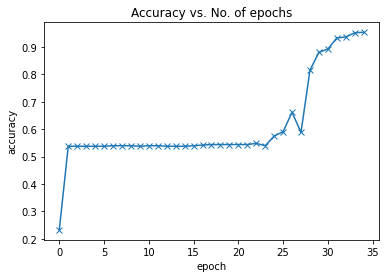

In [25]:
plot_accuracies(history)

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

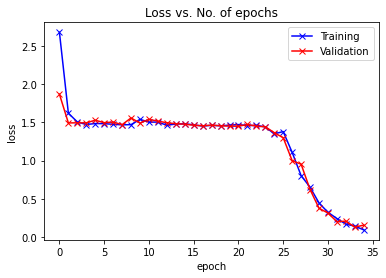

In [27]:
plot_losses(history)